In [1]:
import os
import sys
import cv2
import math
import time
import numpy as np
from util import padRightDownCorner
from config_reader import config_reader
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt

% matplotlib inline

# find connection in the specified sequence
limbSeq = [[3, 2], [2, 0], [2, 1], [3, 4], [3, 5], \
           [3, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], \
           [3, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17]]

# the sort order of mapIdx encodes the map from joint_pairs in training into limbSeq above
mapIdx = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], \
          [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], \
          [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33]]

# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], \
          [0, 255, 0], [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], \
          [0, 0, 255], [85, 0, 255], [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from model.cmu_model import get_testing_model

# load model
keras_weights_file = 'model/keras/mymodel.h5'

model = get_testing_model()
model.load_weights(keras_weights_file)

# load config
resize_fac = 0.5
process_speed = 2
params, model_params = config_reader()

scale_search = params['scale_search']  # [1, 0.5, 1.5, 2]
scale_search = scale_search[0:process_speed]

num_joints = len(model_params['part_str'])  # 18
num_joints_and_bkg = num_joints + 1  # 19
num_connections = len(model_params['joint_pairs'])  # 17
num_paf = 2 * num_connections  # 34

assert num_connections == len(limbSeq) and num_connections == len(mapIdx)


/home/liuqixuan_i/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
input = "dataset/didi1210/"  # can be either a directory or a image file
output_dir = 'outputs/view_process'  # must be a directory for output

output_format = '.jpg'
image_files = []
if os.path.isfile(input):
    name, ext = os.path.splitext(input)
    assert ext in ['.jpg', '.bmp', '.png', '.gif', '.rgb']
    image_files.append(input)
elif os.path.isdir(input):
    for root, dirs, files in os.walk(input):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext in ['.jpg', '.bmp', '.png', '.gif', '.rgb']:
                input_path = os.path.join(root, file)
                image_files.append(input_path)
else:
    raise FileNotFoundError("File not exist in {}".format(input))
os.makedirs(output_dir, exist_ok=True)

def get_output_path(input_path):
    timestr = time.strftime("-%m%d%H%M%S", time.localtime())
    name = os.path.splitext(os.path.basename(input_path))[0]
    output_path = os.path.join(output_dir, name + timestr + output_format)
    while os.path.exists(output_path):
        output_path += "(1)" + output_format
    return output_path

len(image_files)


251

Dropdown(description='input path:', layout=Layout(width='100%'), options=('dataset/didi1210/id100key143_1_20_l…

Text(value='outputs/view_process/id100key143_1_20_lp_pull_d_hair_3.avi-0131200641.jpg', description='output pa…

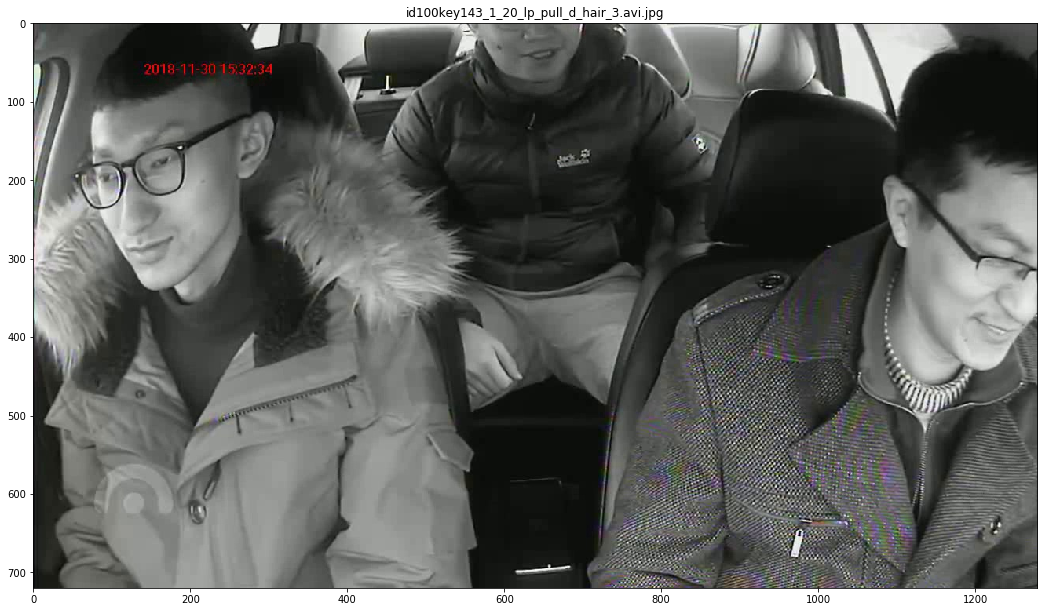

In [4]:
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, clear_output

drop = widgets.Dropdown(description='input path:', options=image_files, layout=Layout(width="100%"))
out_label = widgets.Text(description='output path:', value=get_output_path(drop.value), disabled=True,
                         layout=Layout(width="100%"))
input_path = ''
output_path = ''

def choose_img(path):
    global input_path, output_path
    input_path = path
    output_path = out_label.value = get_output_path(path)
    display(drop, out_label)
    input_image = cv2.imread(input_path)
    plt.figure(figsize=(18, 18))
    plt.title(os.path.basename(path))
    plt.imshow(input_image[:, :, [2, 1, 0]])

def on_drop_change(chg):
    clear_output(wait=False)
    choose_img(chg['new'])

choose_img(drop.value)
drop.observe(on_drop_change, names="value")


[*]Process image dataset/didi1210/id100key143_1_20_lp_pull_d_hair_3.avi.jpg into outputs/view_process/id100key143_1_20_lp_pull_d_hair_3.avi-0131200641.jpg


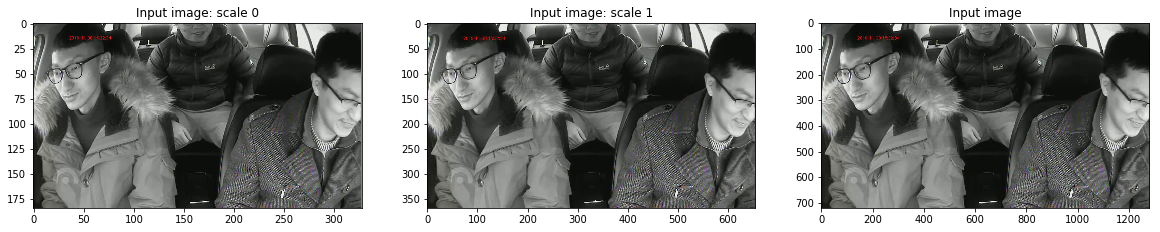

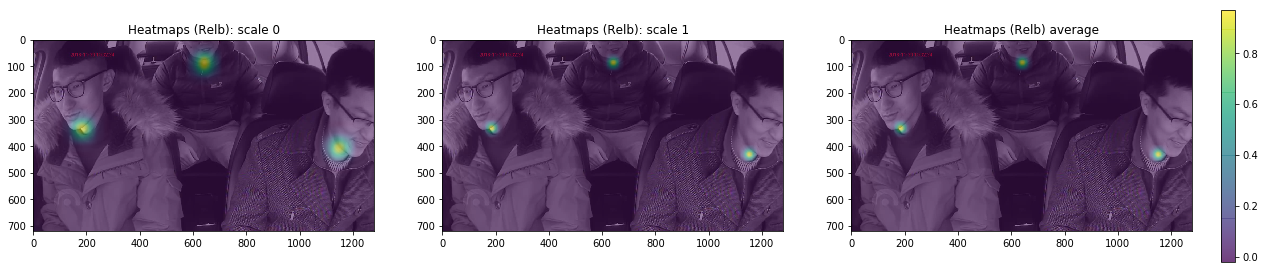

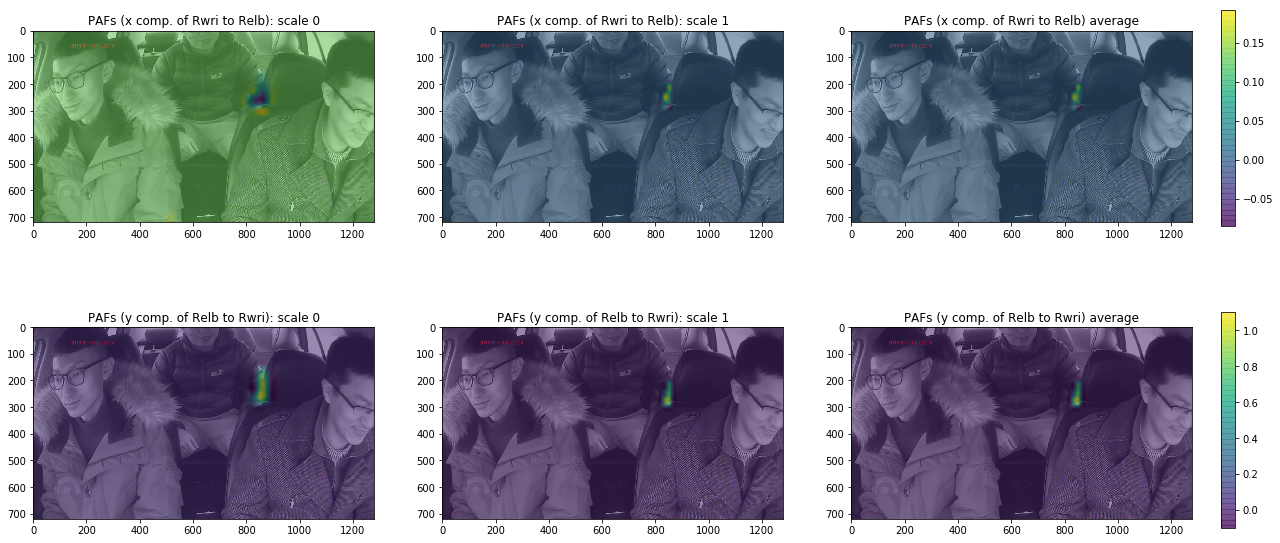

In [8]:
print('[*]Process image {} into {}'.format(input_path, output_path))

# generate image with body parts   
oriImg = cv2.imread(input_path)  # B,G,R order
multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in scale_search]

# first figure shows padded images
f1, axarr1 = plt.subplots(1, len(multiplier) + 1)
f1.set_size_inches((20, 5))
# second figure shows heatmaps
f2, axarr2 = plt.subplots(1, len(multiplier) + 1)
f2.set_size_inches((20, 5))
# third figure shows PAFs
f3, axarr3 = plt.subplots(2, len(multiplier) + 1)
f3.set_size_inches((20, 10))

heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], num_joints_and_bkg))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], num_paf))

for m in range(len(multiplier)):
    scale = multiplier[m]

    img_test = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    img_pad, pad = padRightDownCorner(img_test, model_params['stride'], model_params['padValue'])
    batch_img = np.float32(img_pad[np.newaxis, :, :, :])  # required shape (1, width, height, channels)

    output_blobs = model.predict(batch_img)

    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(output_blobs[1])  # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0, 0), fx=model_params['stride'], fy=model_params['stride'],
                         interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:img_pad.shape[0] - pad[2], :img_pad.shape[1] - pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    # print(heatmap.shape) # (H, W, num_joints_and_bkg)

    paf = np.squeeze(output_blobs[0])  # output 0 is PAFs
    paf = cv2.resize(paf, (0, 0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    paf = paf[:img_pad.shape[0] - pad[2], :img_pad.shape[1] - pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    # print(paf.shape) # (H, W, num_paf)

    # visualization
    axarr1[m].imshow(img_pad[:, :, [2, 1, 0]])
    axarr1[m].set_title('Input image: scale %d' % m)

    axarr2[m].imshow(oriImg[:, :, [2, 1, 0]])
    ax2 = axarr2[m].imshow(heatmap.mean(axis=2), alpha=.5)
    axarr2[m].set_title('Heatmaps (Relb): scale %d' % m)

    axarr3.flat[m].imshow(oriImg[:, :, [2, 1, 0]])
    ax3x = axarr3.flat[m].imshow(paf.mean(axis=2), alpha=.5)
    axarr3.flat[m].set_title('PAFs (x comp. of Rwri to Relb): scale %d' % m)
    axarr3.flat[len(multiplier) + 1 + m].imshow(oriImg[:, :, [2, 1, 0]])
    ax3y = axarr3.flat[len(multiplier) + 1 + m].imshow(paf.mean(axis=2), alpha=.5)
    axarr3.flat[len(multiplier) + 1 + m].set_title('PAFs (y comp. of Relb to Rwri): scale %d' % m)

    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)
# visualization
axarr1[len(multiplier)].imshow(oriImg[:, :, [2, 1, 0]])
axarr1[len(multiplier)].set_title('Input image')

axarr2[len(multiplier)].imshow(oriImg[:, :, [2, 1, 0]])
ax2 = axarr2[len(multiplier)].imshow(heatmap_avg.mean(axis=2), alpha=.5)
axarr2[len(multiplier)].set_title('Heatmaps (Relb) average')

axarr3.flat[len(multiplier)].imshow(oriImg[:, :, [2, 1, 0]])
ax3x = axarr3.flat[len(multiplier)].imshow(paf_avg.mean(axis=2), alpha=.5)
axarr3.flat[len(multiplier)].set_title('PAFs (x comp. of Rwri to Relb) average')
axarr3.flat[len(multiplier) * 2 + 1].imshow(oriImg[:, :, [2, 1, 0]])
ax3y = axarr3.flat[len(multiplier) * 2 + 1].imshow(paf_avg.mean(axis=2), alpha=.5)
axarr3.flat[len(multiplier) * 2 + 1].set_title('PAFs (y comp. of Relb to Rwri) average')

f2.subplots_adjust(right=0.93)
cbar_ax = f2.add_axes([0.95, 0.15, 0.01, 0.7])
_ = f2.colorbar(ax2, cax=cbar_ax)

f3.subplots_adjust(right=0.93)
cbar_axx = f3.add_axes([0.95, 0.57, 0.01, 0.3])
_ = f3.colorbar(ax3x, cax=cbar_axx)
cbar_axy = f3.add_axes([0.95, 0.15, 0.01, 0.3])
_ = f3.colorbar(ax3y, cax=cbar_axy)


In [22]:
all_peaks = []
peak_counter = 0

for part in range(num_joints):
    map_ori = heatmap_avg[:, :, part]
    map = gaussian_filter(map_ori, sigma=3)

    map_left = np.zeros(map.shape)
    map_left[1:, :] = map[:-1, :]
    map_right = np.zeros(map.shape)
    map_right[:-1, :] = map[1:, :]
    map_up = np.zeros(map.shape)
    map_up[:, 1:] = map[:, :-1]
    map_down = np.zeros(map.shape)
    map_down[:, :-1] = map[:, 1:]

    peaks_binary = np.logical_and.reduce(
        (map >= map_left, map >= map_right, map >= map_up, map >= map_down, map > params['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
    peaks_with_score = [x + (map_ori[x[1], x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [23]:
connection_all = []
special_k = []
mid_num = 10

for k in range(num_connections):
    score_mid = paf_avg[:, :, [x for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]]
    candB = all_peaks[limbSeq[k][1]]
    nA = len(candA)
    nB = len(candB)
    if (nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0] * vec[0] + vec[1] * vec[1])
                # failure case when 2 body parts overlaps
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)

                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                    np.linspace(candA[i][1], candB[j][1], num=mid_num)))

                vec_x = np.array(
                    [score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                     for I in range(len(startend))])
                vec_y = np.array(
                    [score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                     for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts) / len(score_midpts) + min(
                    0.5 * oriImg.shape[0] / norm - 1, 0)
                criterion1 = len(np.nonzero(score_midpts > params['thre2'])[0]) > 0.8 * len(
                    score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior,
                                                 score_with_dist_prior + candA[i][2] + candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0, 5))
        for c in range(len(connection_candidate)):
            i, j, s = connection_candidate[c][0:3]
            if (i not in connection[:, 3] and j not in connection[:, 4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if (len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

In [24]:
# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, num_joints + 2))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(num_connections):
    if k not in special_k:
        partAs = connection_all[k][:, 0]
        partBs = connection_all[k][:, 1]
        indexA, indexB = limbSeq[k]

        for i in range(len(connection_all[k])):  # = 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)):  # 1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1

            if found == 1:
                j = subset_idx[0]
                if (subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2:  # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                membership = ((subset[j1] >= 0).astype(int) + (subset[j2] >= 0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0:  # merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else:  # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i, :2].astype(int), 2]) + \
                          connection_all[k][i][2]
                subset = np.vstack([subset, row])

In [25]:
# delete some rows of subset which has few parts occur
deleteIdx = []
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2] / subset[i][-1] < 0.4:
        deleteIdx.append(i)
# subset = np.delete(subset, deleteIdx, axis=0)

In [ ]:
canvas = input_image.copy()
# draw connections
stickwidth = min(max(int(4 * resize_fac), 1), 4)
conn_count = 0
for i in range(num_connections):
    for n in range(len(subset)):
        index = subset[n][limbSeq[i]]
        if -1 in index:
            continue
        # cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY), int(mX)),
                                   (int(length / 2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(canvas, polygon, colors[i])
        conn_count += 1
# draw keypoints
for i in range(num_joints):
    for peak in all_peaks[i]:
        cv2.circle(canvas, peak[0:2], 4, colors[i], thickness=-1)
        cv2.putText(canvas, model_params['part_str'][i], peak[0:2], cv2.FONT_HERSHEY_DUPLEX, 0.3,
                    [255, 255, 255], thickness=1)
# mix
canvas = cv2.addWeighted(canvas, 0.6, input_image, 0.4, 0)
if conn_count < 5:
    return False, canvas
else:
    return True, canvas

toc = time.time()
print('processing time is %.5f' % (toc - tic))